# Gauge transformation of the gauge links in a LC coordinate lattice

## Step 0

### Writting the fields from files

In [3]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = 'su3'

import curraun.su as su
import numpy as np
import pickle

Using SU(3)
Using Numba
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# We read the fields

fields = np.load('gauge_links_fields_glasma_test.npz')
ux = fields['ux']

with open('parameters_gauge_transf_glasma_test.pickle', 'rb') as f:
    param = pickle.load(f)

In [5]:
print(np.shape(ux))

(64, 16384, 9)


In [6]:
# We get the relevant parameters

N = param['N']
Dg = param['DG']

t_steps = np.shape(ux)[0]

In [7]:
# We reshape the transverse component into a N*N matrix

ux_r = ux.reshape((t_steps, N, N, Dg))

print(np.shape(ux_r))

(64, 128, 128, 9)


## Step 1

### We write the relevant magnitude in LC coordinates

In [8]:
# We define a function that, given a set of gauge links, returns the values over the x^+ axis

def get_xplus_axis_links (u):
    uminus = su.GROUP_TYPE(np.zeros((t_steps, N, Dg)))
    for t in range (t_steps):
        uminus[t, :, :] = u[t,t,:,:]
    uplus = np.apply_along_axis(su.dagger, 2, uminus)
    return uplus, uminus

In [9]:
u_plus_temp, u_minus_temp = get_xplus_axis_links(ux_r)

print(np.shape(u_plus_temp))
print(np.shape(u_minus_temp))

(64, 128, 9)
(64, 128, 9)


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 347:
@myjit
def dagger(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


## Step 2

### We gauge transform the relevant quantity to LC gauge

In [10]:
# We construct a function that gives the gauge operator at a given point

def gauge_operator(u, xplus, xminus):
    v = su.GROUP_TYPE(np.array([su.unit() for i in range(N)]))
    for t in range(xplus+xminus):
        buffer1 = v
        aux = u[t, 2*xplus-t, :, :]
        buffer2 = np.apply_along_axis(su.dagger, 1, aux)
        v = np.array([su.mul(buffer1[i, :], buffer2[i, :]) for i in range(N)])
    return v

In [11]:
# We construct an array with the gauge operator over the x^+ axis

v_LC = su.GROUP_TYPE(np.zeros((t_steps, N, Dg)))

for t in range (t_steps):
    v_LC[t,:,:] = gauge_operator(ux_r, t, 0)

print(np.shape(v_LC))

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 371:
@myjit
def unit():
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 119:
@myjit
def mul(a, b):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


(64, 128, 9)


In [12]:
# We construct a function that performs the gauge transformation of the plus links

def act_plus_link (u,v):
    v_h = np.apply_along_axis(su.dagger, 2, v)
    buffer1 = np.array([[su.mul(v[t+1, i, :], u[t, i, :]) for i in range(N)] for t in range(t_steps-1)]) #TODO: What happens with the last step?
    result =  np.array([[su.mul(buffer1[t, i, :], v_h[t, i, :]) for i in range(N)] for t in range(t_steps-1)])
    return result

In [13]:
# We transform the plus link

uplus_LC = act_plus_link(u_plus_temp, v_LC)

print(np.shape(uplus_LC))

(63, 128, 9)


In [14]:
# We plot U_+ at one point of the axis to have some intuition about its value

uplus_LC_r = uplus_LC.reshape((t_steps-1, N, 3, 3))
print(uplus_LC_r[t_steps//2, N//2, :])

[[ 0.96144105-0.05027369j  0.02112951-0.21729964j -0.14506315+0.06629294j]
 [-0.04448342-0.18534159j  0.95623179+0.03487366j -0.045534  +0.21447835j]
 [ 0.18666983+0.04390619j  0.05173538+0.18456015j  0.9623283 +0.02029438j]]


Close to the identity but not exactly

## Step 3

### We transform $U_-$ to LC gauge as a check

In [15]:
# We construct a function with the gauge operator at the next x^- step to the x^+ axis

aux = su.GROUP_TYPE(np.zeros((t_steps, N, Dg)))

for t in range (t_steps):
    aux[t,:,:] = gauge_operator(ux_r, t, 1)

print(np.shape(aux))

(64, 128, 9)


In [16]:
# We construct a function that performs the gauge transformation of the minus links

def act_minus_links(u, v, vplus1): #TODO: Writte the function with only u and v as inputs?
    v_h = np.apply_along_axis(su.dagger, 2, v)
    buffer1 = np.array([[su.mul(vplus1[t, i, :], u[t, i, :]) for i in range(N)] for t in range(t_steps-1)]) #TODO: What happens with the last step?
    result =  np.array([[su.mul(buffer1[t, i, :], v_h[t, i, :]) for i in range(N)] for t in range(t_steps-1)])
    return result

In [17]:
# We transform the minus link

uminus_LC = act_minus_links(u_minus_temp, v_LC, aux)

print(np.shape(uminus_LC))

(63, 128, 9)


In [18]:
# We plot U_- at one point of the axis to check that it is close to identity

uminus_LC_r = uminus_LC.reshape((t_steps-1, N, 3, 3))
print(uminus_LC_r[t_steps//2, N//2, :, :])

[[ 1.00000000e+00+0.00000000e+00j -8.31279490e-15+3.77475828e-15j
  -1.11854970e-14-1.79030282e-16j]
 [-8.29891711e-15-3.78863607e-15j  1.00000000e+00+1.21430643e-17j
   3.10862447e-15-7.56041971e-15j]
 [-1.11299858e-14+2.22044605e-16j  3.08433834e-15+7.52869989e-15j
   1.00000000e+00-2.50189645e-17j]]


The gauge links in minus direction are indeed transformed to the identity. Much closer to 1 that $U_+$ links

# Step 4

### We plot the transformed links

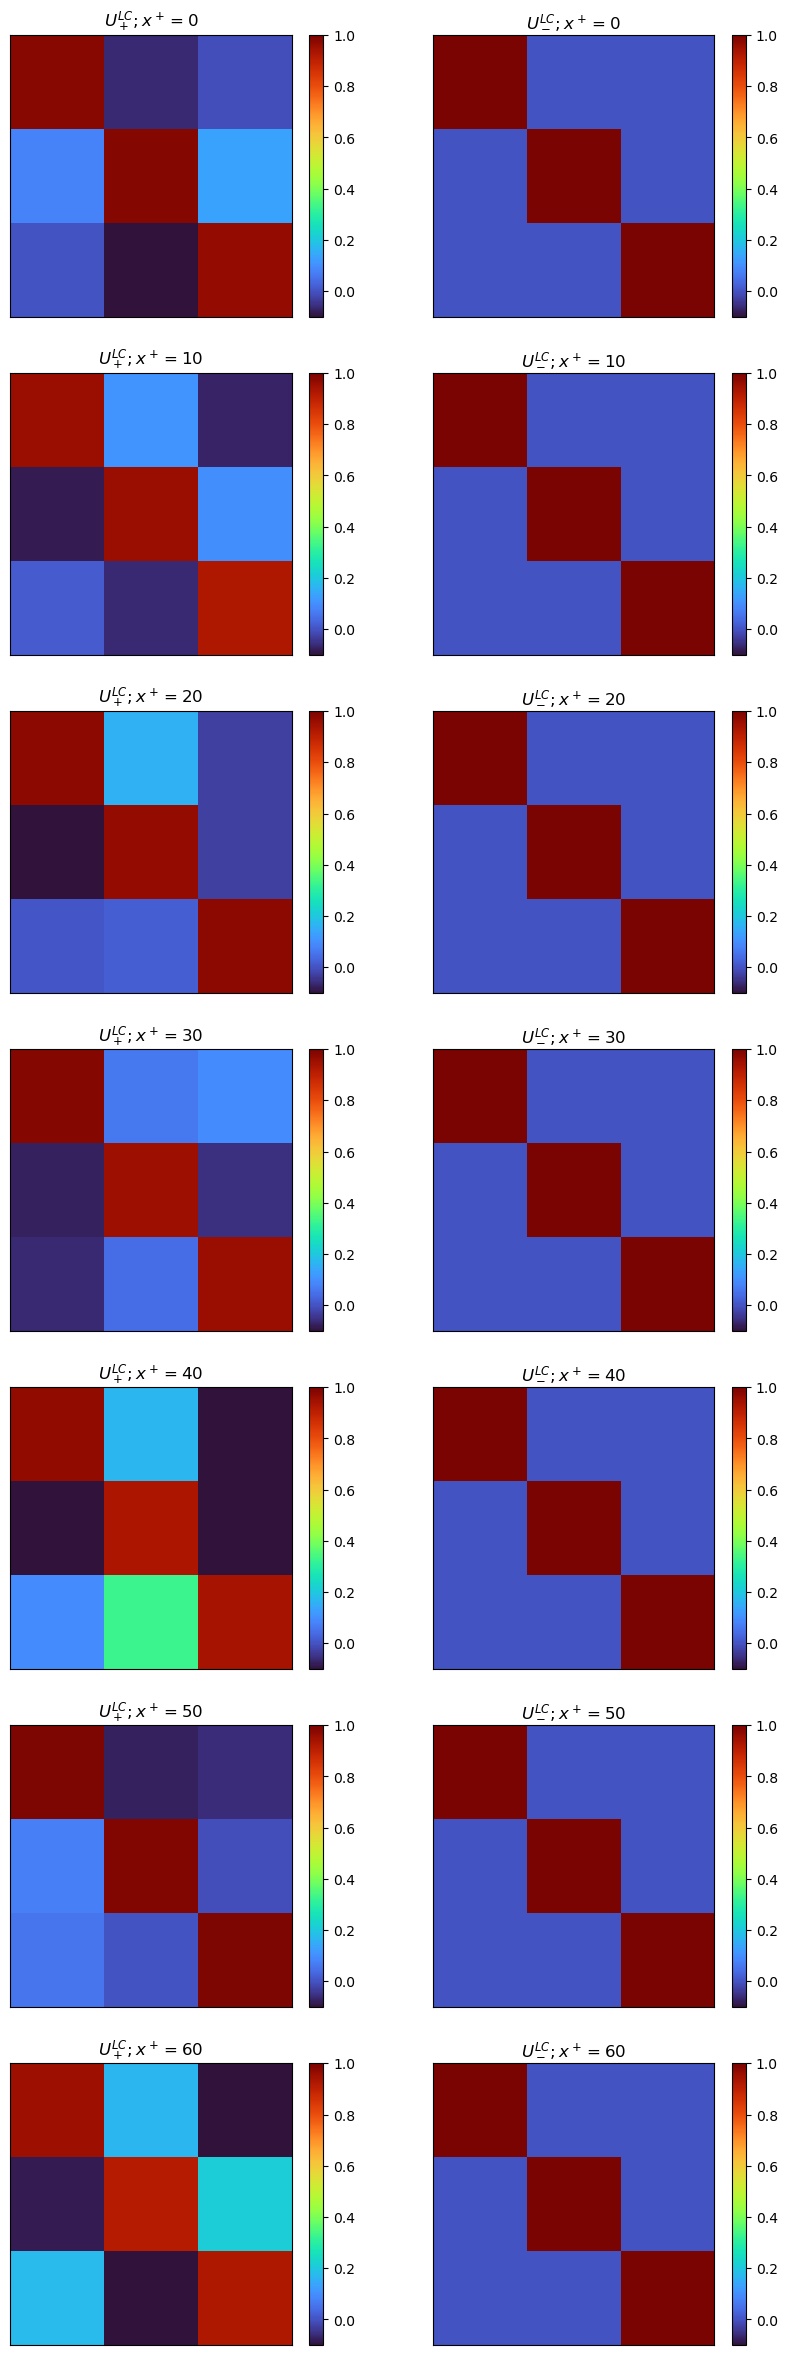

In [19]:
import matplotlib.pyplot as plt 

y = N//2

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_r[tau, y, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uminus_LC_r[tau, y, :, :].real, cmap='turbo', vmin=-0.1, vmax=1)
    axs[t,1].set_title(r'$U_-^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

In [26]:
for t in range (t_steps//10):

    n = su.tr(np.array(su.mul(u_plus_temp[10*t, N//2, :], su.dagger(uplus_LC[10*t, N//2, :]))) - su.unit())
    d = su.sq(u_plus_temp[10*t, N//2, :] - su.unit())

    r = n/d
    print(r)
# plt.imshow(p.real, cmap='turbo', vmin=-0.1, vmax=1) 


(-0.43545867840567715+0.010681594557779981j)
(-8.253658668429253-0.3721170428229103j)
(-0.6227661635576565+0.010763920515429633j)
(-8.445802461570052+0.0870091056798502j)
(-2.472325082776163+0.02419007299067866j)
(-0.5599836889724112+0.01824553756008831j)


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 387:
@myjit
def tr(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
